In [1]:
#!/usr/bin/python

import numpy as np
import pyfits
import os
import environment_utils as envutils

from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from matplotlib import rc, rcParams

# Make use of TeX
rc('text',usetex=True)

# Change all fonts to 'Computer Modern'
rc('font',**{'family':'serif','serif':['Computer Modern']})

In [2]:
envnames = ['Void', 'Sheet', 'Filament', 'Knot']
envcolors = ['red', 'green', 'blue', 'gold']

esdnames = ['esd_total', 'esd_cen', 'esd_sat', 'esd_host', 'esd_2halo']
esdcolors = ['black', 'blue', 'red', 'purple', 'green']

"""
esdnames = ['esd_total', 'esd_cen', 'esd_sat', 'esd_host']
esdcolors = ['black', 'blue', 'red', 'purple']

massnames = ['Mcen', 'Msat', 'Mavg'] # With both fixed
masscolors = ['blue', 'red', 'black']

massnames = ['Mcen', 'Msat', 'Mavg', 'fc_cen'] # With free concentration
masscolors = ['blue', 'red', 'black', 'orange']

massnames = ['Mcen', 'Msat', 'Mavg', 'A_2halo'] # With free 2halo amplitude
masscolors = ['blue', 'red', 'black', 'green']
"""

massnames = ['Mcen', 'Msat', 'Mavg', 'fc_cen', 'A_2halo'] # With both free
masscolors = ['blue', 'red', 'black', 'skyblue', 'green']


plotlabels = ['Average ESD', 'Central', 'Satellite', 'Host', '2-halo term']
masslabels = ['Mcen', 'Msat', 'Mavg', 'fc$^{\r cen}$', 'A$_{\r 2h}$']


#filename = '/disks/shear10/brouwer_veersemeer/mcmc_output/environment_mcmc_output_mstarweight'
#filename = '/disks/shear10/brouwer_veersemeer/mcmc_output/environment_mcmc_output_mstarweight_fcsep'
#filename = '/disks/shear10/brouwer_veersemeer/mcmc_output/environment_mcmc_output_mstarweight_test'
#filename = '/disks/shear10/brouwer_veersemeer/mcmc_output/environment_mcmc_output_mstarweight_no-pointmass'
#filename = '/disks/shear10/brouwer_veersemeer/mcmc_output/environment_mcmc_output_mstarweight_no-pointmass_angsepcor'
#filename = '/disks/shear10/brouwer_veersemeer/mcmc_output/environment_mcmc_output_cen+iso'
#filename = '/disks/shear10/brouwer_veersemeer/mcmc_output/shuffled-environment_mcmc_output_mstarweight'
#filename = '/disks/shear10/brouwer_veersemeer/mcmc_output/shuffled-environment_mcmc_output_mstarweight_no-pointmass'
filename = '/disks/shear10/brouwer_veersemeer/mcmc_output/environment_mcmc_output_fc_A2halo_rankBCG1'

#filename = '/disks/shear10/brouwer_veersemeer/mcmc_output/environment_mcmc_output_auto_fc1' # No 2-halo, fixed fc
#filename = '/disks/shear10/brouwer_veersemeer/mcmc_output/environment_mcmc_output_mstarweight_fcsep' # No 2-halo, fixed fc
#filename = '/disks/shear10/brouwer_veersemeer/mcmc_output/environment_mcmc_output_A2halo' # Free 2-halo, fixed fc
#filename = '/disks/shear10/brouwer_veersemeer/mcmc_output/environment_mcmc_output_fc_A2halo' # Free 2-halo, free fc

#filename = '/disks/shear10/brouwer_veersemeer/mcmc_output/environment_mcmc_output_envS4_rank-999-inf'

burn = 10000
#burn = 0

Importing MCMC results: /disks/shear10/brouwer_veersemeer/mcmc_output/environment_mcmc_output_fc_A2halo_rankBCG1.fits
                   and: /disks/shear10/brouwer_veersemeer/mcmc_output/environment_mcmc_output_fc_A2halo_rankBCG1.hdr
Samples: Created = 50000, Burned = 10000, Used = 40000

Input parameters: ['Mstar' 'fc_sat' 'fsat' 'zgal']
Imported ESD profiles: 4


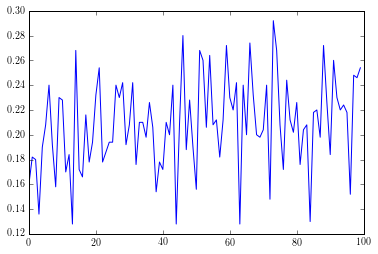

In [3]:
# Import MCMC results
mcmc, end, mcmcname, headername, mcmcmask = envutils.import_mcmc(filename, burn)
print 'Samples: Created = %i, Burned = %i, Used = %i'%(end, burn, len(mcmc['Mcen1']))
print

# Import ESD profiles
esdfiles, covfile, inputparams, acfrac = envutils.read_header(headername)
print 'Input parameters:', np.sort(inputparams.keys())

# Importing the fitted ESD profiles
data_x, data_y, error_h, error_l = envutils.read_esdfiles(esdfiles)

plt.plot(acfrac)

In [4]:
# Taking the median result of all samples after the burn-in phase
def calc_esds_masses(inputparams, mcmc, esdnames, massnames, envnames):
        
    # Import the satellite fraction, and calculate fractions of each component
    fsat = inputparams['fsat']
    esd_fracs = np.array([[1., 1.-fsat[esd], fsat[esd], fsat[esd], 1.] for esd in xrange(len(envnames))])
    
    print 'ESD fractions:'
    print esd_fracs
    print
    
    # Creating the full names of the masses
    masses = np.array([['%s%i'%(m, env+1) \
                        for env in xrange(len(envnames))] \
                        for m in massnames])
   
    # Creating the full names of the ESDs                        
    esds = np.array([['%s%i'%(esd, env+1) \
                    for env in xrange(len(envnames))] \
                    for esd in esdnames])
    
    
    #"""
    # Calculating the median ESD and mass fits, and the error
    sigma = 68.2689492
    percentiles = np.array([50-(sigma/2), 50, 50+(sigma/2)])
    
    print percentiles
    #"""
    
    """
    # Selecting the result with the lowest chi2
    chi2list = mcmc['chi2']
    index = np.where(chi2list == np.amin(chi2list))[0][-1]
    esds_med = np.array([[(mcmc[esds[e,i]])[index] \
                        for e in xrange(len(esdnames))] \
                        for i in xrange(len(envnames))])
    """
    # Calculating the median ESD profiles   
    esds_med = np.array([[[np.percentile(mcmc[esds[e,i]], percentiles[p], axis=0) \
                            for p in xrange(len(percentiles))] \
                            for e in xrange(len(esdnames))] \
                            for i in xrange(len(envnames))])

    # Calculating the median masses
    masses_med = np.array([[[np.percentile(mcmc[masses[m, env]], percentiles[p]) \
                           for p in xrange(len(percentiles))] \
                           for env in xrange(len(envnames))] \
                           for m in xrange(len(massnames))])
    
    return fsat, esd_fracs, esds_med, masses_med, esds, masses, percentiles

In [5]:
# Taking the median result of all samples after the burn-in phase
fsat, esd_fracs, esds_med, masses_med, esds, masses, fracs = calc_esds_masses(inputparams, mcmc, esdnames, massnames, envnames)
print
print esds
print
print masses

ESD fractions:
[[ 1.  1.  0.  0.  1.]
 [ 1.  1.  0.  0.  1.]
 [ 1.  1.  0.  0.  1.]
 [ 1.  1.  0.  0.  1.]]

[ 15.8655254  50.         84.1344746]

[['esd_total1' 'esd_total2' 'esd_total3' 'esd_total4']
 ['esd_cen1' 'esd_cen2' 'esd_cen3' 'esd_cen4']
 ['esd_sat1' 'esd_sat2' 'esd_sat3' 'esd_sat4']
 ['esd_host1' 'esd_host2' 'esd_host3' 'esd_host4']
 ['esd_2halo1' 'esd_2halo2' 'esd_2halo3' 'esd_2halo4']]

[['Mcen1' 'Mcen2' 'Mcen3' 'Mcen4']
 ['Msat1' 'Msat2' 'Msat3' 'Msat4']
 ['Mavg1' 'Mavg2' 'Mavg3' 'Mavg4']
 ['fc_cen1' 'fc_cen2' 'fc_cen3' 'fc_cen4']
 ['A_2halo1' 'A_2halo2' 'A_2halo3' 'A_2halo4']]


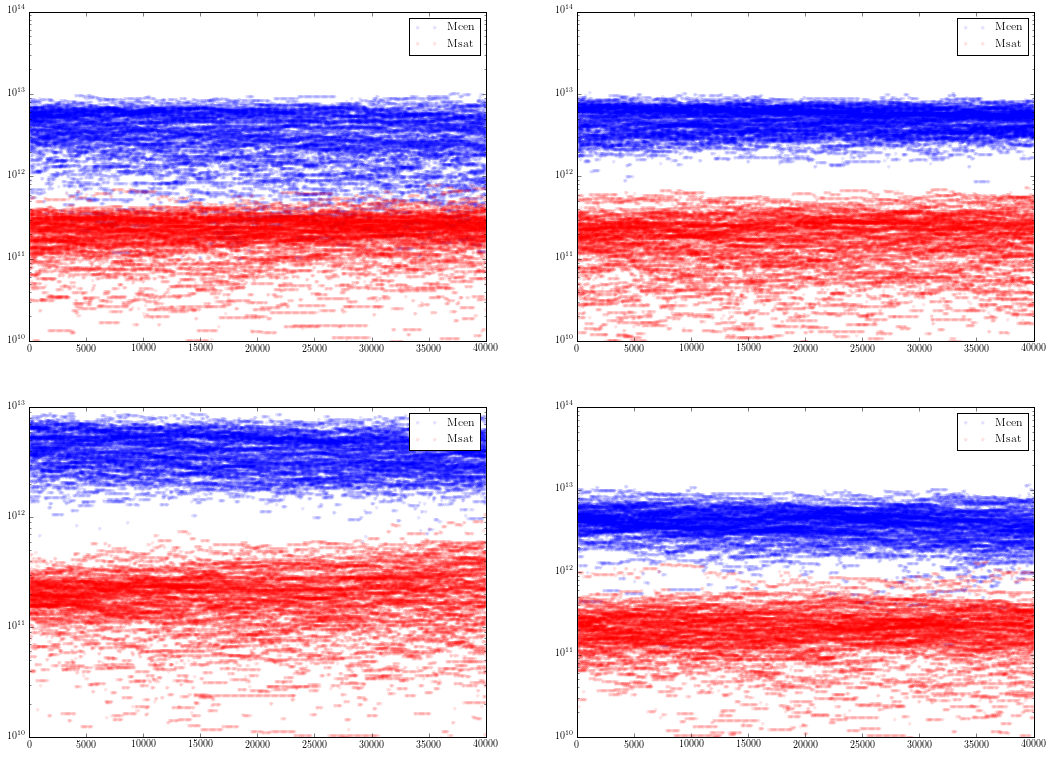

In [6]:
# Checking whether the chain has converged

xlabel = r'Number of iterations'
ylabel = r' Mass (M$_{\odot}$)'

Nrows = 2
Ncolumns = 2

plt.figure(1, figsize=(18, 13))

for e in xrange(len(envnames)):
    for m in xrange(2):
        
        Nsubplot = 100*Nrows+10*Ncolumns+(e+1)
        plt.subplot(Nsubplot)

        plt.plot(mcmc['%s'%masses[m, e]], '.', label=massnames[m], color = masscolors[m], alpha=0.1)
#        plt.plot(mcmc['chi2'], mcmc['%s'%masses[m, e]], '.', label=massnames[m], color = masscolors[m], alpha=0.1)
        
        plt.legend()
        plt.yscale('log')

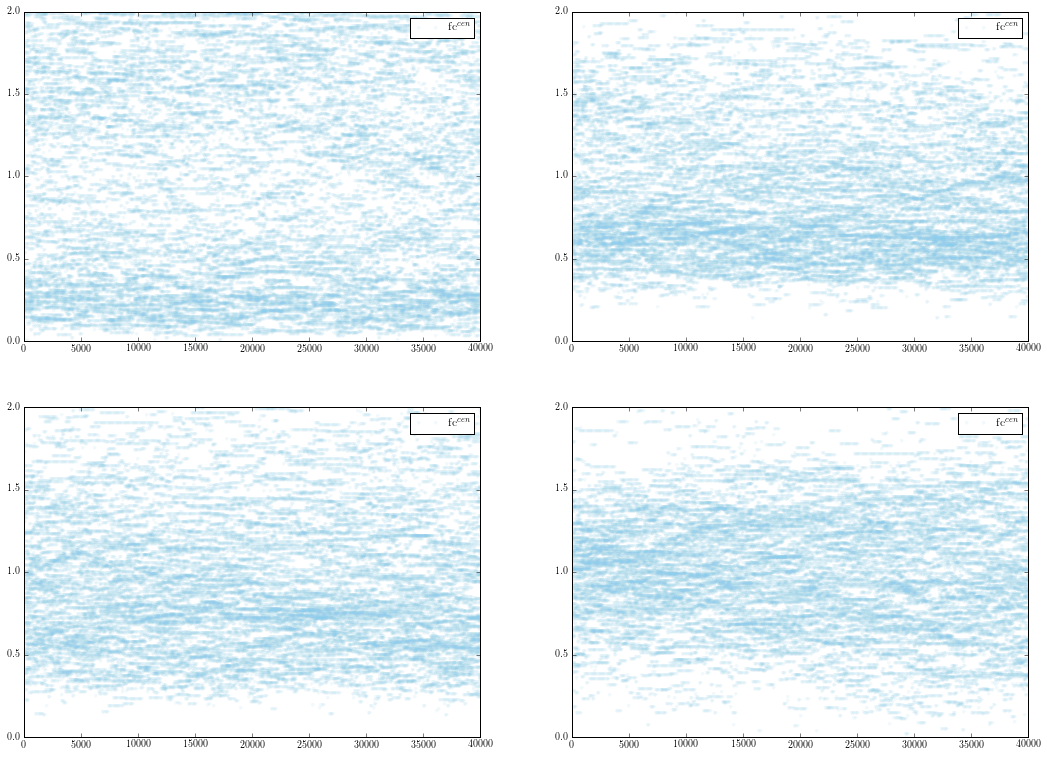

In [7]:
# Checking whether the chain has converged

xlabel = r'Number of iterations'
ylabel = r'%s'%(massnames[3])

Nrows = 2
Ncolumns = 2

plt.figure(1, figsize=(18, 13))

for e in xrange(len(envnames)):
    for m in [3]:
        
        Nsubplot = 100*Nrows+10*Ncolumns+(e+1)
        plt.subplot(Nsubplot)

        plt.plot(mcmc['%s'%masses[m, e]], '.', label=masslabels[m], color = masscolors[m], alpha=0.1)
#        plt.plot(mcmc['chi2'], mcmc['%s'%masses[m, e]], '.', label=massnames[m], color = masscolors[m], alpha=0.1)

        plt.legend()

In [8]:
"""
plt.figure(1, figsize=(15, 13))

f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 7))
f.subplots_adjust(hspace=0.1)

for m in xrange(len(massnames)):
    ax1.semilogy(np.arange(len(envnames)), masses_med[m], '--o', label=massnames[m], color = masscolors[m])

ylabel = r' Mass (M$_{\odot}$)'
xlabel = 'Environment'


ax1.legend(fontsize=15)
    
ax2.plot(np.arange(len(envnames)), masses_med[1]/masses_med[0], '--o', label='%s/%s'%(massnames[1],massnames[0]), color = 'black')
"""

"\nplt.figure(1, figsize=(15, 13))\n\nf, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 7))\nf.subplots_adjust(hspace=0.1)\n\nfor m in xrange(len(massnames)):\n    ax1.semilogy(np.arange(len(envnames)), masses_med[m], '--o', label=massnames[m], color = masscolors[m])\n\nylabel = r' Mass (M$_{\\odot}$)'\nxlabel = 'Environment'\n\n\nax1.legend(fontsize=15)\n    \nax2.plot(np.arange(len(envnames)), masses_med[1]/masses_med[0], '--o', label='%s/%s'%(massnames[1],massnames[0]), color = 'black')\n"

Written: ESD profile plot: /disks/shear10/brouwer_veersemeer/mcmc_output/environment_mcmc_output_fc_A2halo_rankBCG1_masses.pdf


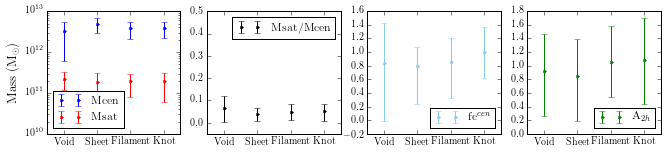

In [9]:
# Create a plot of the masses

Nrows = 1
Ncolumns = 4

x = np.arange(len(envnames))

plt.figure(1, figsize=(11, 2.2))


# Plot Msat and Mcen

Nsubplot = 100*Nrows+10*Ncolumns+(1)
plt.subplot(Nsubplot)

#mass_errors = np.array([abs(masses_med[:,:,1]-masses_med[:,:,x]) for x in [0, 2]]).T

masserrors_up = abs(masses_med[:,:,2] - masses_med[:,:,1])
masserrors_down = abs(masses_med[:,:,1] - masses_med[:,:,0])

for m in xrange(2):
    plt.errorbar(x, masses_med[m,:,1], yerr=[masserrors_up[m], masserrors_down[m]], \
                 ls='', marker='.', label=masslabels[m], color = masscolors[m])

#    plt.fill_between(x, masses_med[m,:,0], masses_med[m,:,2], color = masscolors[m], alpha=0.4)
    
ylabel = r' Mass (M$_{\odot}$)'

plt.yscale('log')
plt.ylabel(r'%s'%ylabel, fontsize=13)
plt.legend(loc='best')
plt.tick_params(axis='both', which='major')
plt.xticks(np.arange(len(envnames)), envnames, visible=True)
plt.xlim(-0.5, 3.5)

# Plot the ratio Msat/Mcen

Nsubplot = 100*Nrows+10*Ncolumns+(2)
plt.subplot(Nsubplot)

massfrac =  masses_med[1,:,1]/masses_med[0,:,1]
massfracerrors_up = massfrac * ( (masserrors_up[0]/masses_med[0,:,1])**2 + (masserrors_up[1]/masses_med[1,:,1])**2 )**0.5
massfracerrors_down = massfrac * ( (masserrors_down[0]/masses_med[0,:,1])**2 + (masserrors_down[1]/masses_med[1,:,1])**2 )**0.5

plt.errorbar(x, massfrac, yerr=[massfracerrors_up, massfracerrors_down], \
             ls='', marker='.', label='%s/%s'%(massnames[1],massnames[0]), color = 'black')

#plt.fill_between(x,(masses_med[1,:,0]/masses_med[0,:,0]), (masses_med[1,:,2]/masses_med[0,:,2]), color = 'blue', alpha=0.4)
#plt.fill_between(x,  massfrac - massfracerrors_down, massfrac + massfracerrors_up, color = 'black', alpha=0.4)

#plt.yscale('log', fontsize=15)
plt.xlim(-0.5, 3.5)
plt.ylim(-0.05, 0.5)
plt.xticks(np.arange(len(envnames)), envnames, visible=True)
#plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc='best')

# Plot the mass concentration relation



for m in [3, 4]:
    Nsubplot = 100*Nrows+10*Ncolumns+(m)
    plt.subplot(Nsubplot)
    
    plt.errorbar(x, masses_med[m,:,1], yerr=[masserrors_up[m], masserrors_down[m]], \
                 ls='', marker='.', label=masslabels[m], color = masscolors[m])
    #plt.fill_between(x, masses_med[m,:,0], masses_med[m,:,2], color = masscolors[m], alpha=0.4)
    
    ylabel = ''
    xlabel = 'Environment'
    
    #plt.yscale('log', fontsize=15)
    plt.ylabel(r'%s'%ylabel)
    plt.legend(loc='best')
#    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xticks(np.arange(len(envnames)), envnames, visible=True)
    plt.xlim(-0.5, 3.5)

plotname = '%s_masses.pdf'%filename

plt.savefig(plotname, format='pdf', bbox_inches='tight')
print 'Written: ESD profile plot:', plotname


Written: ESD profile plot: /disks/shear10/brouwer_veersemeer/mcmc_output/environment_mcmc_output_fc_A2halo_rankBCG1_masshists.pdf


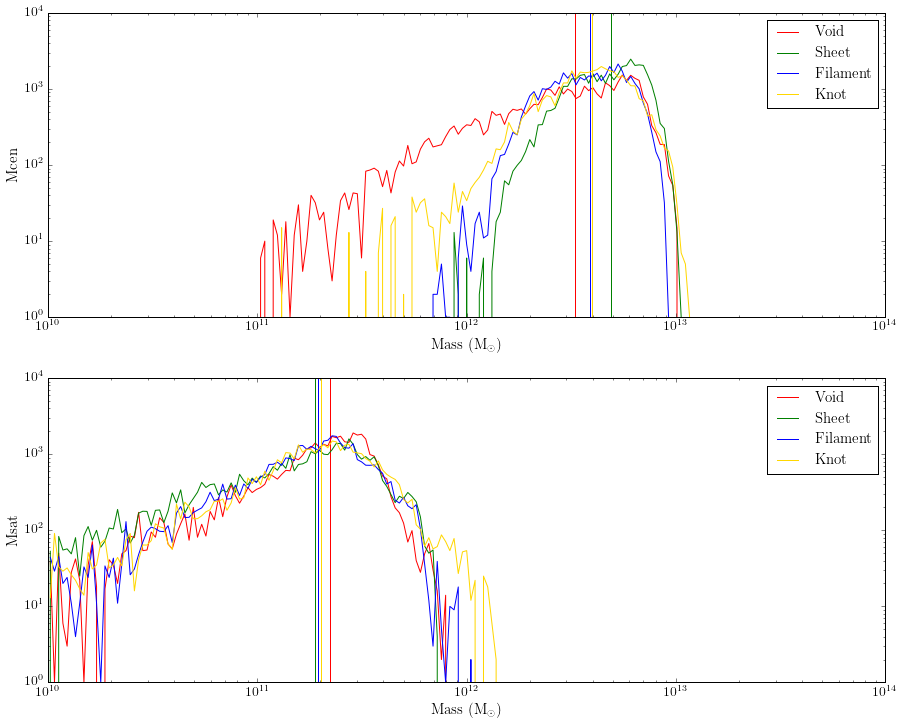

In [10]:
# Create a plot of the mass histograms

nbins = 2e2

histmin = 1e10
histmax = 1e14
histbins = np.logspace(np.log10(histmin), np.log10(histmax), nbins)
histbins = np.append(histbins, histmax)
histcens = [(histbins[i]+histbins[i+1])/2 for i in xrange(len(histbins)-1)]

plt.figure(1, figsize=(15, 12), dpi=80)

xlabel = r' Mass (M$_{\odot}$)'

Nrows = 2
Ncolumns = 1

for m in xrange(Nrows):
    
    Nsubplot = 100*Nrows+10*Ncolumns+(m+1)
    plt.subplot(Nsubplot)

    for e in xrange(len(envnames)):
    
        obsname = masses[m, e]
        median = masses_med[m, e, 1]
        obslist = (mcmc[obsname])
        
        hist, histbins = np.histogram(obslist, histbins)
        
        plt.plot(histcens, hist, color=envcolors[e], label=envnames[e])
        plt.axvline(x = median, color=envcolors[e])

        plt.legend(fontsize=15)
        
        plt.xlabel(r'%s'%xlabel,fontsize=15)
        plt.ylabel(r'%s'%massnames[m],fontsize=15)
        plt.tick_params(axis='both', which='major', labelsize=14)
        
        plt.xscale('log')
        plt.yscale('log')

plotname = '%s_masshists.pdf'%filename

plt.savefig(plotname, format='pdf', bbox_inches='tight')
print 'Written: ESD profile plot:', plotname

Written: ESD profile plot: /disks/shear10/brouwer_veersemeer/mcmc_output/environment_mcmc_output_fc_A2halo_rankBCG1.pdf


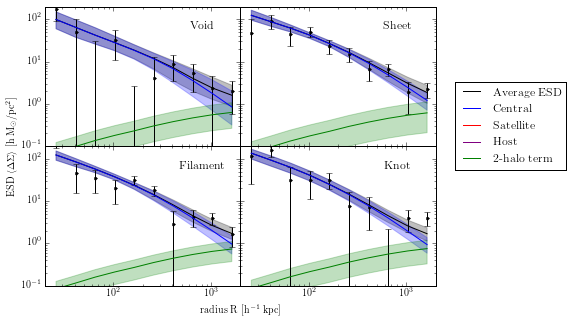

In [11]:
from matplotlib import gridspec
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Create a plot of the ESD profiles and halo model fit

# Define the labels for the plot
h=1
xlabel = r'radius R [$\rm h^{-1}$ kpc]'
ylabel = r'ESD $\langle\Delta\Sigma\rangle$ [h M$_{\odot}$/pc$^2$]'

Nrows = 2
Ncolumns = 2

# Plotting the ueber matrix
fig = plt.figure(figsize=(7,5))
canvas = FigureCanvas(fig)

gs_full = gridspec.GridSpec(1,1)
gs = gridspec.GridSpecFromSubplotSpec(Nrows, Ncolumns, wspace=0, hspace=0, subplot_spec=gs_full[0,0])

ax = fig.add_subplot(gs_full[0,0])

for N1 in xrange(Nrows):
    for N2 in xrange(Ncolumns):

        env = N1*Nrows + N2    
        
        # Plot the ESD profile
        (error_l[env])[(error_l[env])>=data_y[env]] = ((data_y[env][(error_l[env])>=data_y[env]])*0.9999999999)

        ax_sub = fig.add_subplot(gs[N1, N2])
        ax_sub.errorbar(data_x, data_y[env], yerr=[error_l[env], error_h[env]], ls='', marker='.', color = 'black')
        
        for esd in xrange(len(esdnames)):

            # Plot the fitted halo model
            ax_sub.plot(data_x, esds_med[env, esd, 1]*esd_fracs[env, esd], label=r'%s'%plotlabels[esd], color = esdcolors[esd])

            fill_up = esds_med[env, esd, 0]*esd_fracs[env, esd]
            fill_down = esds_med[env, esd, 2]*esd_fracs[env, esd]

            plt.fill_between(data_x, fill_up, fill_down, color = esdcolors[esd], alpha=0.25)
            
        ax_sub.xaxis.set_label_position('top')
        ax_sub.yaxis.set_label_position('right')

        ax.tick_params(labelleft='off', labelbottom='off', top='off', bottom='off', left='off', right='off')
                
        if N2 != 0:
            ax_sub.tick_params(axis='y', labelleft='off')
        if N2 == Ncolumns-1:
            ax_sub.set_xticks(np.arange(9.,12.,0.5))
        else:
            ax_sub.set_xticks(np.arange(9.,11.5,0.5))
        
        
        plt.autoscale(enable=False, axis='both', tight=None)
        plt.axis([2e1,2e3,1e-1,1e3])
        plt.ylim(1e-1,2e2)
        plt.xscale('log')
        plt.yscale('log')
        
            
        plt.title(envnames[env], x = 0.8, y = 0.8)

lgd = ax_sub.legend(bbox_to_anchor=(1.7, 1.5))

# Define the labels for the plot
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.xaxis.set_label_coords(0.5, -0.07)
ax.yaxis.set_label_coords(-0.07, 0.5)

#ax.xaxis.label.set_size(17)
#ax.yaxis.label.set_size(17)
        
# Save plot
plotname = '%s.pdf'%filename

plt.savefig(plotname, format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
print 'Written: ESD profile plot:', plotname

#plt.clf


In [12]:
# Showing the difference between cosmic and shuffled environments

In [13]:
# Importing the data from the shuffled environments
filename_shuff = '/disks/shear10/brouwer_veersemeer/mcmc_output/shuffled_environment_mcmc_output_fc_A2halo' # Free 2-halo, free fc

# Import MCMC results
mcmc_shuff, end, mcmcname_shuff, headername_shuff, mcmcmask = envutils.import_mcmc(filename_shuff, burn)
print 'Samples: Created = %i, Burned = %i, Used = %i'%(end, burn, len(mcmc['Mcen1']))
print

# Import ESD profiles
esdfiles, covfile, inputparams_shuff, acfrac = envutils.read_header(headername_shuff)
print 'Input parameters:', np.sort(inputparams.keys())

# Taking the median result of all samples after the burn-in phase
fsat_shuff, esd_fracs_shuff, esds_med_shuff, masses_med_shuff, esds_shuff, masses_shuff, fracs_shuff = calc_esds_masses(inputparams_shuff, mcmc_shuff, esdnames, massnames, envnames)


Importing MCMC results: /disks/shear10/brouwer_veersemeer/mcmc_output/shuffled_environment_mcmc_output_fc_A2halo.fits
                   and: /disks/shear10/brouwer_veersemeer/mcmc_output/shuffled_environment_mcmc_output_fc_A2halo.hdr
Samples: Created = 50000, Burned = 10000, Used = 40000

Input parameters: ['Mstar' 'fc_sat' 'fsat' 'zgal']
ESD fractions:
[[ 1.          0.83449478  0.16550522  0.16550522  1.        ]
 [ 1.          0.7524769   0.2475231   0.2475231   1.        ]
 [ 1.          0.64612054  0.35387946  0.35387946  1.        ]
 [ 1.          0.50711315  0.49288685  0.49288685  1.        ]]

[ 15.8655254  50.         84.1344746]


Written: ESD profile plot: /disks/shear10/brouwer_veersemeer/mcmc_output/environment_mcmc_output_fc_A2halo_rankBCG1_shuffhist.pdf


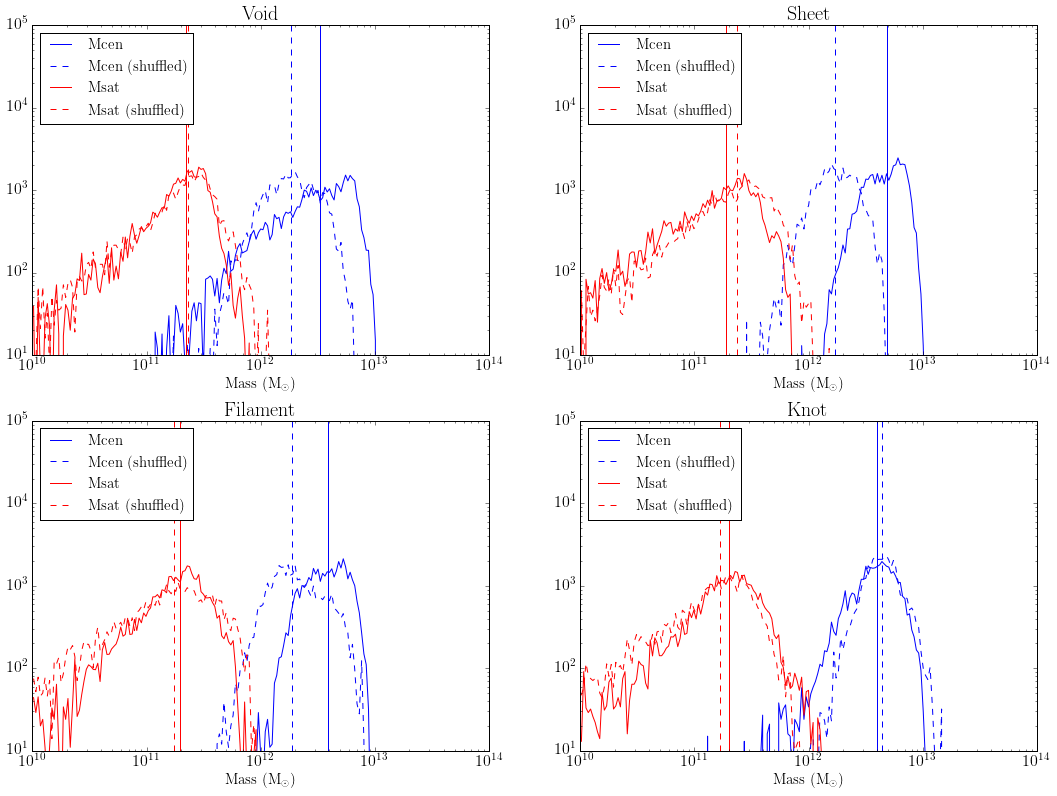

In [14]:
# Creating a plot of the difference between cosmic and shuffled environments

# Define the labels for the plot
h=1
xlabel = r' Mass (M$_{\odot}$)'

Nrows = 2
Ncolumns = 2

for e in xrange(len(envnames)):
    for m in xrange(2):
        plt.figure(1, figsize=(18, 13))
        Nsubplot = 100*Nrows+10*Ncolumns+(e+1)
        plt.subplot(Nsubplot)
        
        obsname = masses[m, e]
        
        median = [masses_med[m, e, 1], masses_med_shuff[m, e, 1]]
        obslist = [mcmc[obsname], mcmc_shuff[obsname]]
        
        label_add = ['', ' (shuffled)']
        linestyles = ['-', '--']
        
        
        for s in xrange(2): # For both cosmic and shuffled environment ...
            
            hist, histbins = np.histogram(obslist[s], histbins)
            plt.plot(histcens, hist, color=masscolors[m], label='%s%s'%(massnames[m], label_add[s]), linestyle = linestyles[s])
            plt.axvline(x = median[s], color=masscolors[m], linestyle = linestyles[s])
        
        plt.xlabel(r'%s'%xlabel,fontsize=15)
    

    plt.title(envnames[e], fontsize=20)
   
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.xscale('log', fontsize=15)
    plt.yscale('log', fontsize=15)
            
#    plt.autoscale(enable=False, axis='both', tight=None)
#    plt.axis([1e1,5e3,1e-1,1e3])
    plt.ylim(1e1,1e5)
        
    plt.legend(fontsize=15, loc='upper left')

plotname = '%s_shuffhist.pdf'%filename

plt.savefig(plotname, format='pdf')
print 'Written: ESD profile plot:', plotname


[0.0, 0.0, 0.0, 0.0]
[0.165505215448, 0.247523098454, 0.353879461123, 0.492886851943]
Written: ESD profile plot: /disks/shear10/brouwer_veersemeer/mcmc_output/environment_mcmc_output_fc_A2halo_rankBCG1_fsat.pdf


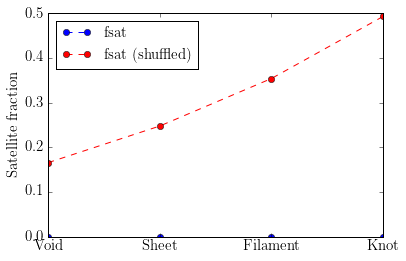

In [15]:
fsats = [fsat, fsat_shuff]

print fsat
print fsat_shuff

# Plot fsat
for s in xrange(2):
    plt.plot(x, fsats[s], ls='--', marker='o', label='%s%s'%('fsat', label_add[s]), color = masscolors[s])

ylabel = r'Satellite fraction'

#plt.yscale('log', fontsize=15)
plt.ylabel(r'%s'%ylabel, fontsize=15)
plt.legend(fontsize=15, loc='upper left')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(np.arange(len(envnames)), envnames, visible=True)
plt.xlim(0,3)

plotname = '%s_fsat.pdf'%filename

plt.savefig(plotname, format='pdf')
print 'Written: ESD profile plot:', plotname